<b> Loading the necessary packages for the rest of the notebook </b>

In [18]:
import yfinance as yf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import datetime
import ta
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import MinMaxScaler
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import Lasso
from sklearn.datasets import load_diabetes

<b> In this section we define the timeframe that we will work with, we chose to get the data from 01/01/2009 till 01/01/2022 and we get one data point for each day, this makes for a dataset of ... entries <b/>

In [19]:
start = datetime.datetime(2009,1,1)
end = datetime.datetime(2022,1,21)
windows = [15,30,45,60]

<b> In this section we get the data we need to work with using the seperate Data_Processing notebook (check the notebook for detailed processing and feature selection) and we visualize the first 5 data entries that we have <b/>

In [20]:
from ipynb.fs.full.Data_Processing import *

gold = get_data(start,end,windows)


DOWNLOADING THE DATA FROM YAHOO FINANCE ....
[*********************100%***********************]  1 of 1 completed
ADDING TECHNICAL INDICATORS ...
SELECTING THE BEST FEATURES ....


In [21]:
gold.head()

,High,Low,Open,SMA_30,SMA_45,SMA_60,Close
Date,,,,,,,
2009-03-30,932.500000,908.599976,924.599976,938.973330,930.335552,909.468330,915.500000
2009-03-31,924.500000,911.599976,918.000000,937.493329,930.648885,910.198330,922.599976
2009-04-01,932.500000,916.900024,918.599976,935.773328,931.246662,911.346662,926.099976
2009-04-02,930.299988,894.900024,926.900024,933.483329,931.675552,912.046662,907.400024
2009-04-03,910.299988,891.299988,904.599976,929.943329,931.464441,912.954996,895.599976


In [22]:
## Differencing the data for 
def difference(dataset, interval=1):
    diff = list()
    for i in range(interval, len(dataset)):
        value = dataset.iloc[i] - dataset.iloc[i - interval]
        diff.append(value)
    return diff

In [23]:
def get_flattened(data,window_size):
    X,Y = [],[]
    for i in range(0,len(data)-window_size):
        X.append(data.iloc[i:i+window_size,:].T.to_numpy().flatten())
        Y.append(data.Close[i+window_size])
    return np.array(X),np.array(Y)

In [24]:
def get_unflattened(data,window_size):
    X,Y = [],[]
    for i in range(0,len(data)-window_size):
        X.append(data.iloc[i:i+window_size,:])
        Y.append(data.Close[i+window_size])
    return np.array(X),np.array(Y)

In [25]:
final_data = gold.copy()

## Scaling the data

In [26]:
from sklearn.preprocessing import MinMaxScaler as mms

In [27]:
input_scaler = mms(feature_range=(-1,1))
selected_features = final_data.columns[0:6]
print(selected_features)


Index(['High', 'Low', 'Open', 'SMA_30', 'SMA_45', 'SMA_60'], dtype='object')


In [28]:
final_data[selected_features] = input_scaler.fit_transform(final_data[selected_features])

In [29]:
final_data.head()

,High,Low,Open,SMA_30,SMA_45,SMA_60,Close
Date,,,,,,,
2009-03-30,-0.904321,-0.925787,-0.905159,-0.922184,-0.955397,-1.000000,915.500000
2009-03-31,-0.917797,-0.920681,-0.916376,-0.924972,-0.954794,-0.998576,922.599976
2009-04-01,-0.904321,-0.911660,-0.915357,-0.928212,-0.953645,-0.996336,926.099976
2009-04-02,-0.908027,-0.949106,-0.901249,-0.932526,-0.952820,-0.994971,907.400024
2009-04-03,-0.941717,-0.955234,-0.939152,-0.939194,-0.953226,-0.993199,895.599976


In [30]:
output_scaler = mms(feature_range=(-1,1))
final_data.Close = output_scaler.fit_transform(final_data.Close.to_numpy().reshape(-1, 1))
final_data.head()

,High,Low,Open,SMA_30,SMA_45,SMA_60,Close
Date,,,,,,,
2009-03-30,-0.904321,-0.925787,-0.905159,-0.922184,-0.955397,-1.000000,-0.918757
2009-03-31,-0.917797,-0.920681,-0.916376,-0.924972,-0.954794,-0.998576,-0.906765
2009-04-01,-0.904321,-0.911660,-0.915357,-0.928212,-0.953645,-0.996336,-0.900853
2009-04-02,-0.908027,-0.949106,-0.901249,-0.932526,-0.952820,-0.994971,-0.932438
2009-04-03,-0.941717,-0.955234,-0.939152,-0.939194,-0.953226,-0.993199,-0.952369


In [31]:
## Shift the close column by 1
#final_data["Close"] = final_data.Close.shift(-1)
#final_data = final_data.dropna()
#final_data.head()

In [32]:
x,y = get_unflattened(final_data,5)

In [33]:
x.shape,y.shape

((3220, 5, 7), (3220,))

In [34]:
final_data.shape

(3225, 7)

### Models

In [35]:
def plot_time_series(Y_test,test_predictions):
    plt.figure(figsize=(13, 8))
    plt.plot(Y_test, marker='.')
    plt.plot(test_predictions,marker='+', c='orange')
    plt.xlabel("Time")
    plt.ylabel("Value")
    plt.grid(True)
    plt.legend(["True Value","$\hat{y}$"])
    plt.show()

In [99]:
def train(model,X_train,Y_train,X_test, Y_test,epochs):
    ## In order to perform early stopping
    callbacks = tf.keras.callbacks.EarlyStopping(
    monitor="mae",
    patience=4,
    verbose=0,
    mode="auto",
    baseline=None,
    restore_best_weights=True,
    )
    
    model.fit(X_train, Y_train,
                    validation_data=(X_test, Y_test),
                    verbose=0,
                    epochs=epochs,callbacks=[callbacks])

In [100]:
def plot_error(error):
    plt.plot(error,c='red')
    plt.xlabel("Time")
    plt.ylabel("Error Value")
    plt.title("TEST ERROR PLOT")
    plt.show()

In [101]:
from sklearn.metrics import mean_absolute_error as mae

def evaluate(model,X_test,output_scaler,Y_test):
    test_predictions = model.predict(X_test) 
    test_predictions = output_scaler.inverse_transform(test_predictions.flatten().reshape(-1, 1))
    test_predictions = test_predictions.flatten()
    Y_test = output_scaler.inverse_transform(Y_test.flatten().reshape(-1, 1))
    plot_time_series(Y_test,test_predictions)
    MAE = mae(Y_test,test_predictions)
    print("MAE TEST ERROR IS: ",mae(Y_test,test_predictions))
    error = Y_test.flatten()-test_predictions.flatten()
    plot_error(error)
    return MAE

In [102]:
from sklearn.model_selection import train_test_split
from keras.layers.core import Dense, Activation, Dropout
from keras.layers.recurrent import LSTM
from keras.models import Sequential
import keras
import tensorflow as tf

In [105]:
n = len(x)
X_train = x[0:int(n*0.7)]
X_val = x[int(n*0.7):int(n*0.9)]
X_test = x[int(n*0.9):]


Y_train = y[0:int(n*0.7)]
Y_val = y[int(n*0.7):int(n*0.9)]
Y_test = y[int(n*0.9):]

In [124]:
Y_train.shape
Y_test.shape

(322,)

### LSTM Architechture

In [107]:
## Creating the model architechture and training it:
model = tf.keras.models.Sequential([
  tf.keras.layers.LSTM(units = 90,
                       return_sequences=True,
                       batch_input_shape=(None, X_train.shape[1],X_train.shape[2])), # [None,60,1] #[batch, time steps, dimension]
    tf.keras.layers.LSTM(units = 60,
                       return_sequences=True),
    tf.keras.layers.LSTM(units = 40,
                       return_sequences=False),

  tf.keras.layers.Dense(1),
])
print(model.summary())
optimizer = tf.keras.optimizers.Adam(learning_rate=0.0006)

model.compile(loss = "mse",
              metrics ="mae",
              optimizer = optimizer)

Model: "sequential_14"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_36 (LSTM)               (None, 5, 90)             35280     
_________________________________________________________________
lstm_37 (LSTM)               (None, 5, 60)             36240     
_________________________________________________________________
lstm_38 (LSTM)               (None, 40)                16160     
_________________________________________________________________
dense_14 (Dense)             (None, 1)                 41        
Total params: 87,721
Trainable params: 87,721
Non-trainable params: 0
_________________________________________________________________
None


In [108]:
epochs = 300
train(model,X_train,Y_train,X_test, Y_test,epochs)

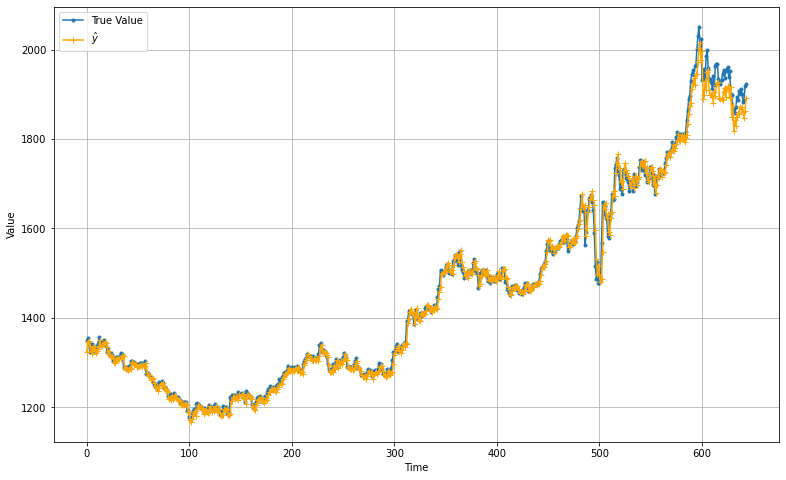

MAE TEST ERROR IS:  12.447817405558519


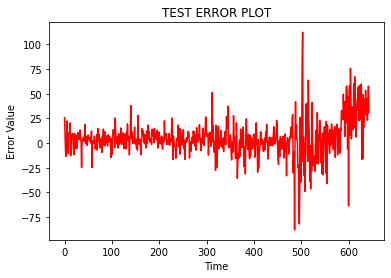

12.447817405558519

In [109]:
evaluate(model,X_val,output_scaler,Y_val)

### BiDirectional LSTM Architechture

In [110]:
## Creating the model architechture and training it:
Bi_LSTM = tf.keras.models.Sequential([
  tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(units = 90,
                       return_sequences=True,
                       batch_input_shape=(None, X_train.shape[1],X_train.shape[2]))), # [None,60,1] #[batch, time steps, dimension]
    
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(units = 60,
                       return_sequences=True)),
    
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(units = 40,
                       return_sequences=False)),
    
  tf.keras.layers.Dense(1),
])

optimizer = tf.keras.optimizers.Adam(learning_rate=0.0006)

Bi_LSTM.compile(loss = "mse",
              metrics ="mae",
              optimizer = optimizer)

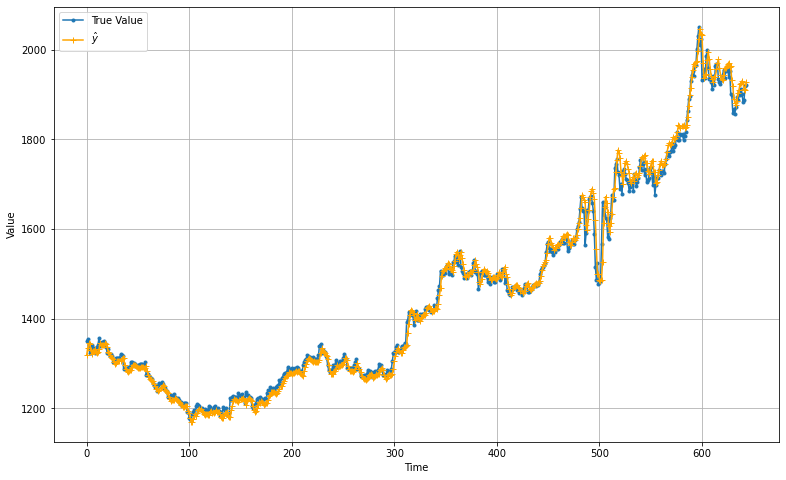

MAE TEST ERROR IS:  13.183604364809783


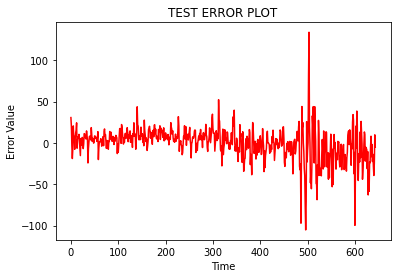

13.183604364809783

In [111]:
epochs = 300
train(Bi_LSTM,X_train,Y_train,X_test, Y_test,epochs)
evaluate(Bi_LSTM,X_val,output_scaler,Y_val)

### GRU Architechture


In [112]:
## Creating the model architechture and training it:
GRU_model = tf.keras.models.Sequential([
  tf.keras.layers.GRU(units = 90,
                       return_sequences=True,
                       batch_input_shape=(None, X_train.shape[1],X_train.shape[2])), # [None,60,1] #[batch, time steps, dimension]
    
    tf.keras.layers.GRU(units = 60,
                       return_sequences=True),
    
    tf.keras.layers.GRU(units = 40,
                       return_sequences=False),
    
  tf.keras.layers.Dense(1),
])
print(GRU_model.summary())
optimizer = tf.keras.optimizers.Adam(learning_rate=0.0006)

GRU_model.compile(loss = "mse",
              metrics ="mae",
              optimizer = optimizer)

Model: "sequential_16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru_6 (GRU)                  (None, 5, 90)             26730     
_________________________________________________________________
gru_7 (GRU)                  (None, 5, 60)             27360     
_________________________________________________________________
gru_8 (GRU)                  (None, 40)                12240     
_________________________________________________________________
dense_16 (Dense)             (None, 1)                 41        
Total params: 66,371
Trainable params: 66,371
Non-trainable params: 0
_________________________________________________________________
None


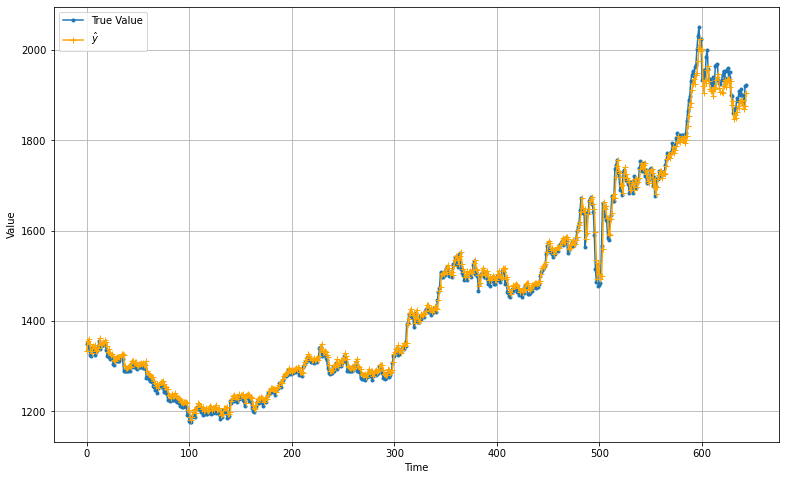

MAE TEST ERROR IS:  12.377140400572591


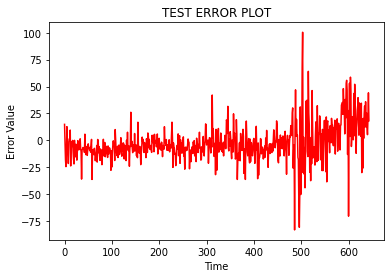

12.377140400572591

In [113]:
epochs = 300
train(GRU_model,X_train,Y_train,X_test, Y_test,epochs)
evaluate(GRU_model,X_val,output_scaler,Y_val)

### BiDirectional GRU Architechture

In [114]:
## Creating the model architechture and training it:
GRU_model = tf.keras.models.Sequential([
  tf.keras.layers.Bidirectional(tf.keras.layers.GRU(units = 90,
                       return_sequences=True,
                       batch_input_shape=(None, X_train.shape[1],X_train.shape[2]))), # [None,60,1] #[batch, time steps, dimension]
    
   tf.keras.layers.Bidirectional(tf.keras.layers.GRU(units = 60,
                       return_sequences=True)),
    
    tf.keras.layers.Bidirectional(tf.keras.layers.GRU(units = 40,
                       return_sequences=False)),
    
  tf.keras.layers.Dense(1),
])

optimizer = tf.keras.optimizers.Adam(learning_rate=0.0006)

GRU_model.compile(loss = "mse",
              metrics ="mae",
              optimizer = optimizer)

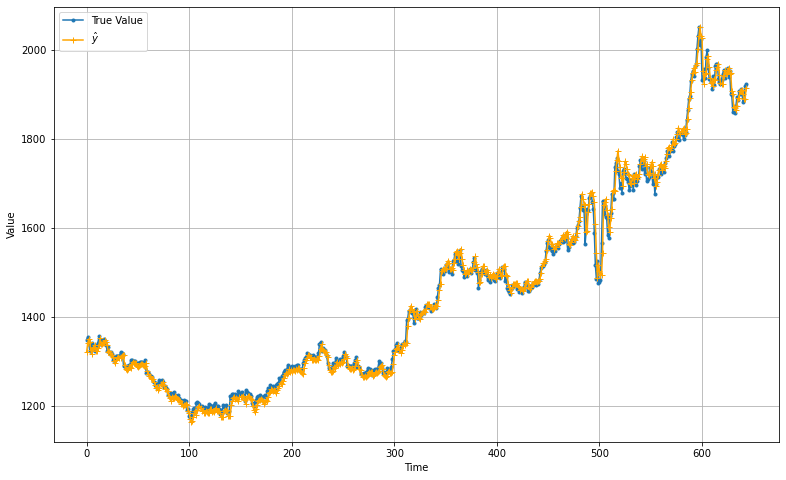

MAE TEST ERROR IS:  11.903034091736217


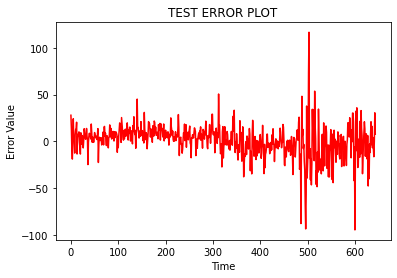

11.903034091736217

In [115]:
epochs = 300
train(GRU_model,X_train,Y_train,X_test, Y_test,epochs)
evaluate(GRU_model,X_val,output_scaler,Y_val)

### Trying out AUTO ARIMA

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(1,0,1)[12] intercept   : AIC=-10300.184, Time=0.93 sec
 ARIMA(0,1,0)(0,0,0)[12] intercept   : AIC=-10309.720, Time=0.32 sec
 ARIMA(1,1,0)(1,0,0)[12] intercept   : AIC=-10308.007, Time=1.97 sec
 ARIMA(0,1,1)(0,0,1)[12] intercept   : AIC=-10308.032, Time=2.75 sec
 ARIMA(0,1,0)(0,0,0)[12]             : AIC=-10311.284, Time=0.21 sec
 ARIMA(0,1,0)(1,0,0)[12] intercept   : AIC=-10308.558, Time=0.31 sec
 ARIMA(0,1,0)(0,0,1)[12] intercept   : AIC=-10308.574, Time=0.37 sec
 ARIMA(0,1,0)(1,0,1)[12] intercept   : AIC=-10306.510, Time=0.65 sec
 ARIMA(1,1,0)(0,0,0)[12] intercept   : AIC=-10309.329, Time=0.17 sec
 ARIMA(0,1,1)(0,0,0)[12] intercept   : AIC=-10309.330, Time=0.34 sec
 ARIMA(1,1,1)(0,0,0)[12] intercept   : AIC=-10307.330, Time=0.60 sec

Best model:  ARIMA(0,1,0)(0,0,0)[12]          
Total fit time: 8.638 seconds


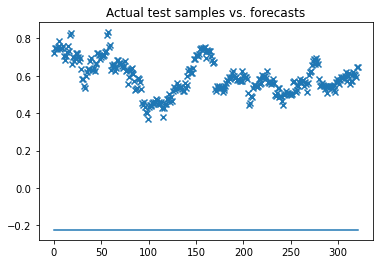

In [126]:
import pmdarima as pm
from pmdarima import model_selection
import numpy as np
from matplotlib import pyplot as plt

arima = pm.auto_arima(Y_train, error_action='ignore', trace=True,
                      suppress_warnings=True, maxiter=5,
                      seasonal=True, m=12)

x = np.arange(Y_test.shape[0])
plt.scatter(x,Y_test, marker='x')
plt.plot(x, arima.predict(n_periods=Y_test.shape[0]))
plt.title('Actual test samples vs. forecasts')
plt.show()
